In [54]:
import os
import cv2
import numpy as np
from skimage import data, color, feature
import matplotlib.pyplot as plt
from skimage import transform

In [55]:
def make_data_from_folder(path):
  data = []
  for img in os.listdir(path):
    if img != ".DS_Store":
      pic = cv2.imread(os.path.join(path,img))
      pic = cv2.cvtColor(pic,cv2.COLOR_BGR2RGB)
      # pic = cv2.resize(pic,(80,80))
      data.append(pic)
  return data

In [56]:
def plot_images(images):
  fig, ax = plt.subplots(3, 5, figsize=(32, 16))
  for i, axi in enumerate(ax.flat):
      axi.imshow(images[i], cmap='gray')
      axi.axis('off')

In [57]:
def apply_gray(images):
  return [color.rgb2gray(img) for img in images]

In [58]:
def apply_crop(images,x1,x2,y1,y2):
    #200:400,300:600
  return [img[x1:x2,y1:y2] for img in images]

In [59]:
correct_data = make_data_from_folder('/Users/bormilan/Documents/plm_kepek_detect/test2/0')
incorrect_data = make_data_from_folder('/Users/bormilan/Documents/plm_kepek_detect/test2/1')

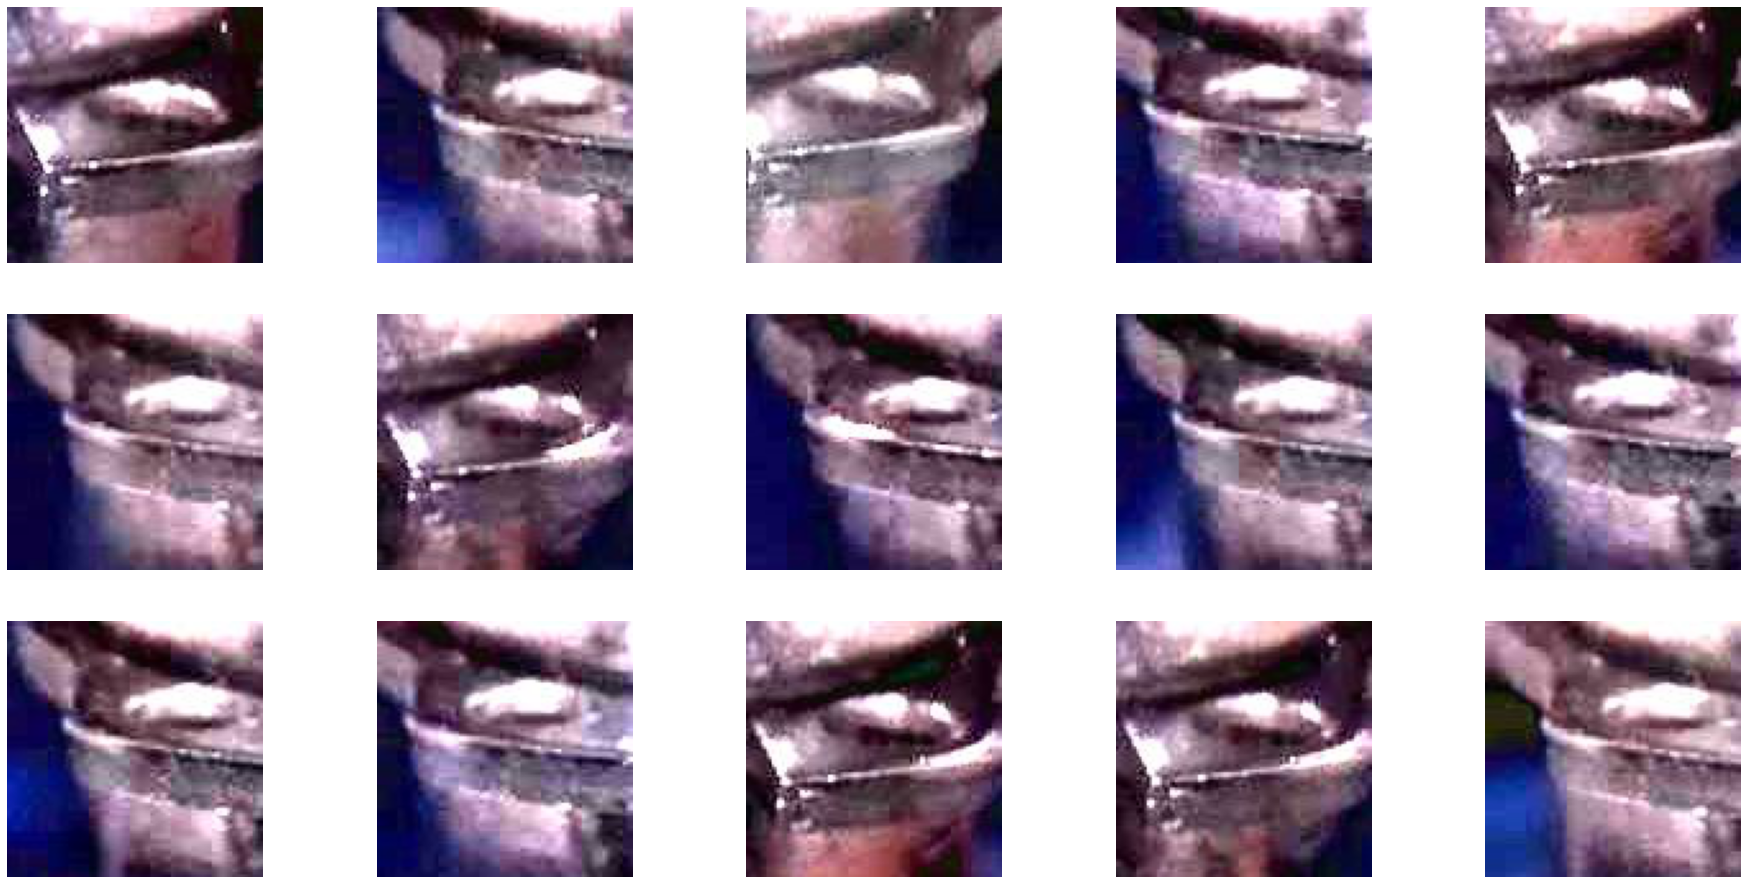

In [60]:
plot_images(correct_data)

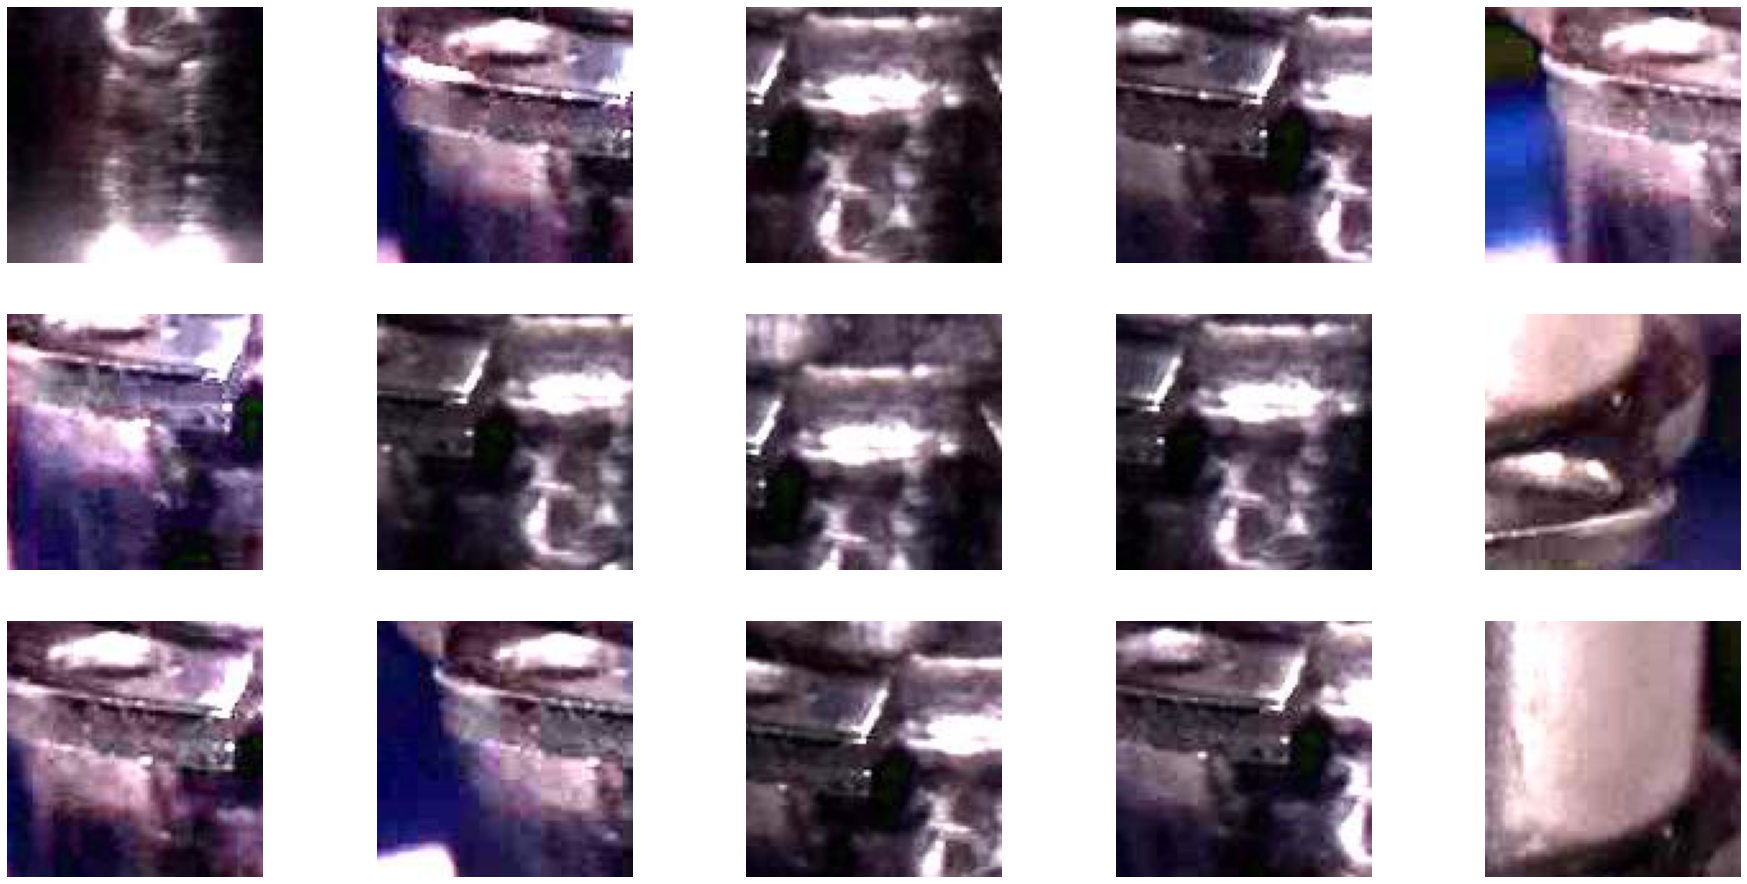

In [61]:
plot_images(incorrect_data)

In [62]:
print(len(correct_data))
print(len(incorrect_data))

65
467


Kiegyensúlyozottnak tekintem

In [63]:
test_images = make_data_from_folder('/Users/bormilan/Documents/plm_kepek_detect/test_crop')
# test_images = make_data_from_folder('/Users/bormilan/Documents/plm_kepek_detect/test4')

In [64]:
test_images_gray = apply_gray(test_images)
test_images_crop = test_images_gray
# test_images_crop = apply_crop(test_images_gray, 230, 470, 380, 820)

Ilyen képeket szeretnénk:

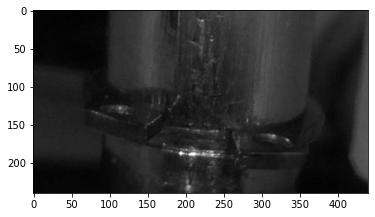

In [65]:
plt.imshow(test_images_crop[7], cmap="gray")

In [66]:
test_images_crop[7].shape

(240, 440)

Ilyeneket detektálni:

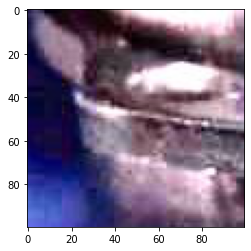

In [67]:
plt.imshow(correct_data[1], cmap="gray")

In [68]:
positive_patches = apply_gray(correct_data)
negative_patches = apply_gray(incorrect_data)

In [69]:
# negative_patches = [cv2.resize(img, dsize=(100, 100), interpolation=cv2.INTER_CUBIC) for img in negative_patches]

In [70]:
positive_patches = np.stack(positive_patches, axis=0)
negative_patches = np.stack(negative_patches, axis=0)

In [71]:
print(positive_patches[0].shape)
print(negative_patches.shape)

(100, 100)
(467, 100, 100)


In [72]:
from itertools import chain
X_train = np.array([feature.hog(im)
                    for im in chain(positive_patches,
                                    negative_patches)])
y_train = np.zeros(X_train.shape[0])
y_train[:positive_patches.shape[0]] = 1

In [73]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

names = [
    "Nearest Neighbors",
    #"Linear SVM",
    #"RBF SVM",
    #"Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "Naive Bayes"
    #"QDA",
]

classifiers = [
    KNeighborsClassifier(),
    #SVC(kernel="linear", C=0.025),
    #SVC(gamma=2, C=1),
    #GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    GaussianNB()
    #QuadraticDiscriminantAnalysis(),
]

In [74]:
from sklearn.model_selection import cross_val_score

for i, cf in enumerate(classifiers):
  print(f"{names[i]}: {cross_val_score(cf, X_train, y_train)}")

Nearest Neighbors: [1.         0.95327103 0.99056604 0.98113208 0.97169811]
Decision Tree: [0.93457944 0.98130841 0.9245283  0.91509434 0.91509434]
Random Forest: [0.87850467 0.87850467 0.88679245 0.90566038 0.87735849]
Neural Net: [1.         1.         1.         0.98113208 1.        ]
Naive Bayes: [1. 1. 1. 1. 1.]


In [75]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier()
model.fit(X_train, y_train)

KNeighborsClassifier()

In [76]:
# import joblib
# filename = 'model_knn.sav'
# joblib.dump(model, filename)

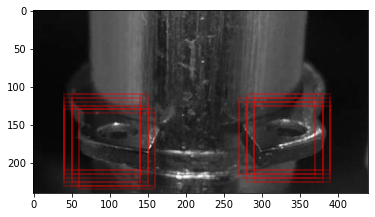

In [77]:
def sliding_window(img, patch_size=positive_patches[0].shape,
                   istep=5, jstep=10, scale=1.0):
  
    fig, ax = plt.subplots()
    ax.imshow(img, cmap='gray')

    Ni, Nj = (int(scale * s) for s in patch_size)
    for i in range(0, img.shape[0] - Ni, istep):
        for j in range(0, img.shape[1] - Ni, jstep):

            koords = ()

            patch = img[i:i + Ni, j:j + Nj]
            if scale != 1:
                patch = transform.resize(patch, patch_size)
            
            #prediktáljuk hogy ez egy seeger fog-e, hog reprezentáció alapján
            label = 0
            if (i > 60 and i < 150) and ((j < 100 and j > 25) or (j > 225 and j < 300)): 
              label = model.predict(feature.hog(patch).reshape(1, -1))

            #ha az akkor rajzoljunk négyzetet köré és adjuk vissza az értékeket
            if label == 1:
              koords = ((j, i), (j + Nj, i + Ni))
              ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red',
                                alpha=0.2, lw=2, facecolor='none'))
            yield (i, j, koords)
            
indices, patches, koords = zip(*sliding_window(test_images_crop[3]))

In [78]:
def vis_points(img, koords):
  img = img
  fig, ax = plt.subplots()
  ax.imshow(img, cmap='gray')

  for k in koords:
    if k != ():
      # print(k)
      o = int((k[0][0] + k[1][0]) / 2), int((k[0][1] + k[1][1]) / 2)

      ax.add_patch(plt.Circle(o, 0.5, color = 'r'))
      # cv2.circle(img, o, 10, (0,0,255), -1)

  plt.imshow(img, cmap = 'gray')

In [79]:
test_image = test_images_crop[8]

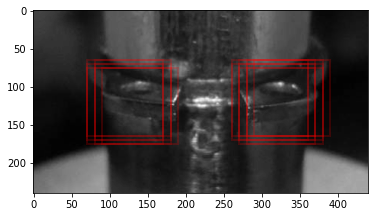

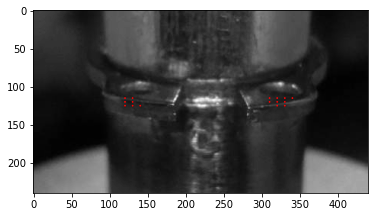

In [80]:
indices, patches, koords = zip(*sliding_window(test_image))

vis_points(test_image, koords)

In [81]:
import numpy as np

In [82]:
koords = list(koords)

In [83]:
type(koords)

list

In [84]:
print(len(koords))

952


In [85]:
for i, k in enumerate(koords):
  if k == ():
    koords.pop(i)

In [86]:
import pandas as pd

In [87]:
koords = pd.unique(pd.Series(koords))

In [88]:
new_koords = []
for i, k in enumerate(koords):
  for j, l in enumerate(koords):
    if k != () and l != ():
      o1 = int((k[0][0] + k[1][0]) / 2), int((k[0][1] + k[1][1]) / 2)
      o2 = int((l[0][0] + l[1][0]) / 2), int((l[0][1] + l[1][1]) / 2)

      # print(np.linalg.norm(np.array(o2) - np.array(o1)))
      if i != j and np.linalg.norm(np.array(o2) - np.array(o1)) < 10:
        new_koords.append(k)
        break

In [89]:
print(len(new_koords))

14


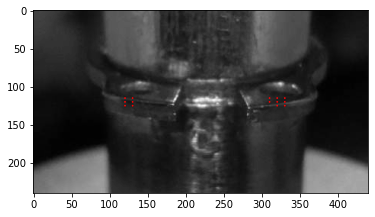

In [90]:
vis_points(test_image, new_koords)

In [91]:
a_koords = [new_koords[0]]
b_koords = []

for k in new_koords[1:len(new_koords)]:
  if k != ():
    l = a_koords[0]
    o1 = int((k[0][0] + k[1][0]) / 2), int((k[0][1] + k[1][1]) / 2)
    o2 = int((l[0][0] + l[1][0]) / 2), int((l[0][1] + l[1][1]) / 2)

      # print(np.linalg.norm(np.array(o2) - np.array(o1)))
    if np.linalg.norm(np.array(o2) - np.array(o1)) < 50:
      a_koords.append(k)
    else:
      b_koords.append(k)

In [92]:
koords[1]

((70, 65), (170, 165))

In [93]:
print(len(a_koords))
print(len(b_koords))

6
8


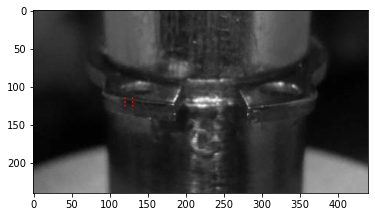

In [94]:
vis_points(test_image, a_koords)

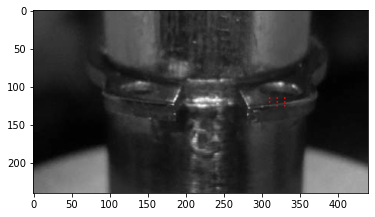

In [95]:
vis_points(test_image, b_koords)

In [96]:
def calc_distances(a_koords, b_koords):
  distances = []
  for a, b in zip(a_koords, b_koords):
    o1 = int((a[0][0] + a[1][0]) / 2), int((a[0][1] + a[1][1]) / 2)
    o2 = int((b[0][0] + b[1][0]) / 2), int((b[0][1] + b[1][1]) / 2)

    distances.append(np.linalg.norm(np.array(o2) - np.array(o1)))

  return distances 

In [97]:
distances = calc_distances(a_koords, b_koords)
print(np.mean(distances))

195.03074930847518


In [98]:
def distance_measurement(img):
  #predict with sliding window
  indices, patches, koords = zip(*sliding_window(img))
  #plot result
  # vis_points(img, koords)

  #tuples into list
  koords = list(koords)

  new_koords = []
  #delete empty units
  for k in koords:
    if k != ():
      new_koords.append(k)

  # vis_points(img, koords)
  
  #delete duplicate units
  # new_koords = pd.unique(pd.Series(koords))
  # vis_points(img, new_koords)
  # print(new_koords)
  #separete points
  a_koords = [new_koords[1]]
  b_koords = []

  for k in new_koords[2:len(new_koords)]:
    l = a_koords[0]
    o1 = int((k[0][0] + k[1][0]) / 2), int((k[0][1] + k[1][1]) / 2)
    o2 = int((l[0][0] + l[1][0]) / 2), int((l[0][1] + l[1][1]) / 2)

      # print(np.linalg.norm(np.array(o2) - np.array(o1)))
    if np.linalg.norm(np.array(o2) - np.array(o1)) < 50:
      a_koords.append(k)
    else:
      b_koords.append(k)

  # vis_points(img, a_koords)
  # vis_points(img, b_koords)

  distances = calc_distances(a_koords, b_koords)
  result = False
  if np.mean(distances) > 200:
    vis_points(img, new_koords)

  return np.mean(distances)
  # return result

197.20628676601316

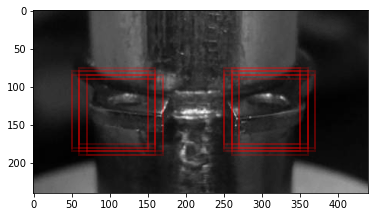

In [99]:
distance_measurement(test_images_crop[2])

197.20628676601316
202.23748416156684


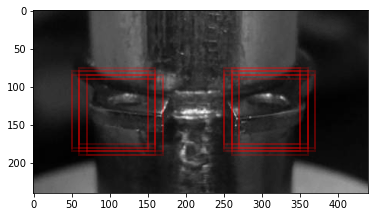

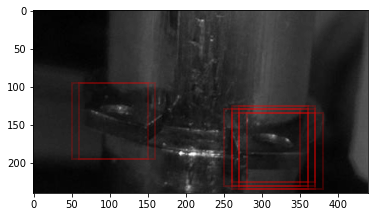

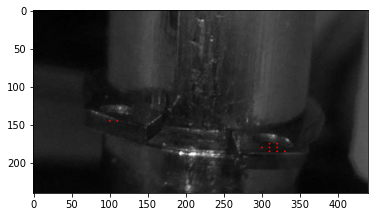

In [100]:
a_distance = distance_measurement(test_images_crop[2])
b_distance = distance_measurement(test_images_crop[7])

print(a_distance)
print(b_distance)

[196.7018183349385,
 223.08025942760457,
 197.20628676601316,
 234.10493890843986,
 212.53771907710734,
 236.74054855907428,
 235.60747563234702,
 202.23748416156684,
 193.41516633961427]

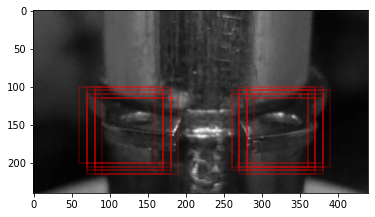

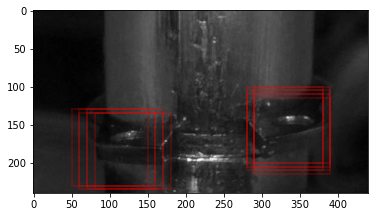

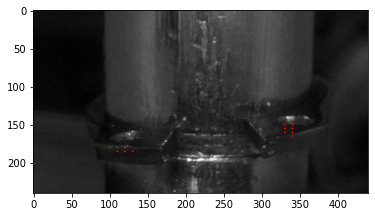

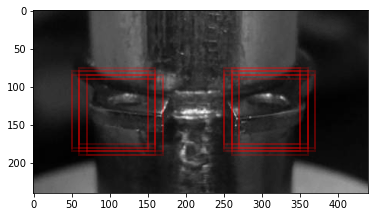

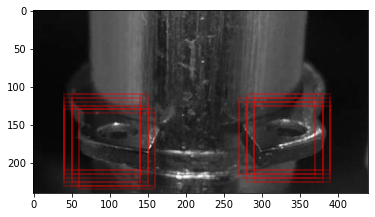

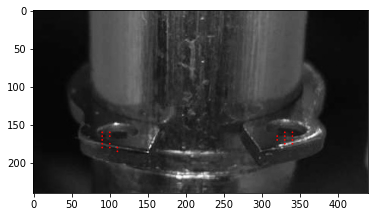

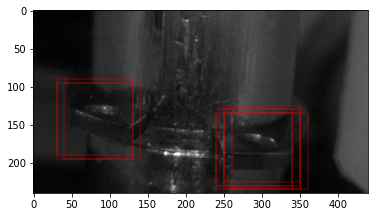

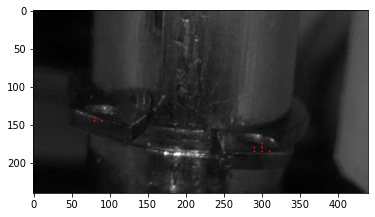

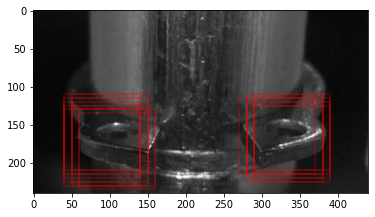

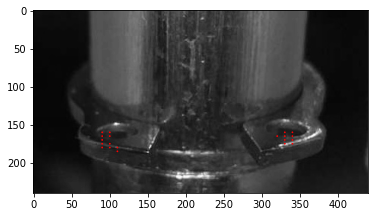

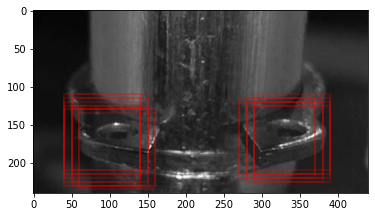

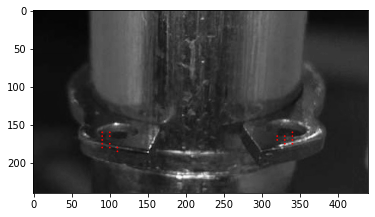

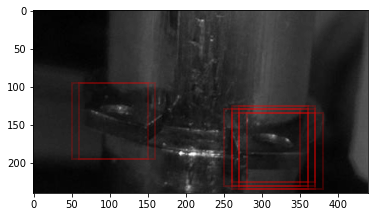

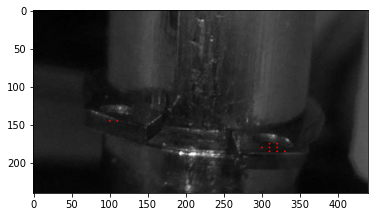

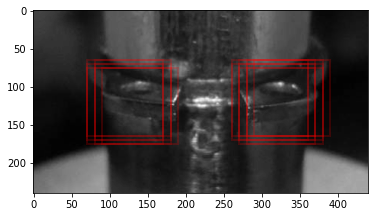

In [101]:
distances = []

for img in test_images_crop:
  temp = distance_measurement(img)
  distances.append(temp)

distances